# <span style="color:orange">GluonTS:</span> Deep Learning for Forecasting

---
> ## Table of contents
> 1. ### <span style="color:orange">What is GluonTS?</span>
> 2. ### <span style="color:orange">Quick start guide</span>
    2.1 Download a dataset  
    2.2 Train an existing model  
    2.3 Evaluate the model  
    2.4 Exercise 1  
    2.5 Exercise 2  
> 3. ### <span style="color:orange">Custom datasets and models</span>
    3.1 Datasets   
    3.2 Probabilistic forecasting with a feedforward neural network   
    3.3 Exercise 3    
> ### <span style="color:orange">Appendix</span>    
>    A.1 Solution to Exercise 1  
>    A.2 Solution to Exercise 2   
>    A.3 Solution to Exercise 3 
---

In [1]:
# % pip install gluonts

In [2]:
# import gluonts

# 1. What is GluonTS?

GluonTS is a Python toolkit for probabilistic time series modeling, built around Apache MXNet (incubating).

GluonTS is especially suited for working with multiple time series datasets. It provides utilities for loading and iterating over time series datasets, state of the art models ready to be trained, as well as building blocks to define your own models and quickly experiment with different solutions.

The toolkit is not intended as a forecasting solution for businesses. Instead, it targets scientists and engineers who want to tweak algorithms or build and experiment with their own models. 

Usefull links:  
https://github.com/awslabs/gluon-ts  
https://gluon-ts.mxnet.io/  

# 2. Quick start guide

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## 2.1 Download a dataset

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


To download one of the built-in datasets, simply call `get_dataset` with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=False)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` containts metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

In [5]:
len(list(dataset.train))

414

In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))

In [7]:
# get the first time series in the test set
test_entry = next(iter(dataset.test))

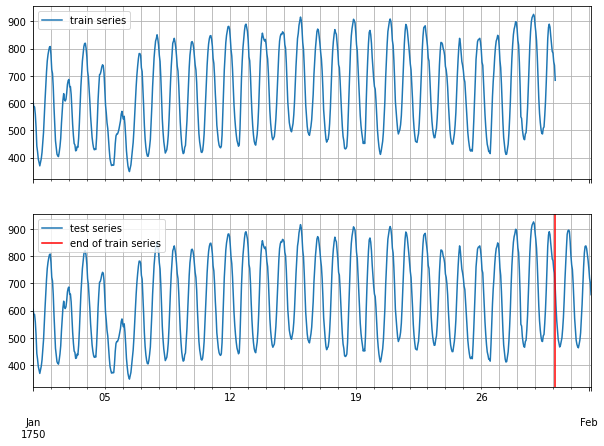

In [8]:
# convert the timeseries to pandas series objects to make plotting easier
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## 2.2 Train an existing model 

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [12]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

The code block below creates the feedforward network estimator. There are many more available options than the ones we have used here, which are described in the documentation. The `SimpleFeedForwardEstimator` documentation is available at:   
https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.simple_feedforward.html.

In [15]:
estimator = SimpleFeedForwardEstimator(
    # required
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    # optional
    num_hidden_dimensions=[10],    
    context_length=100, 
    trainer=Trainer(
        ctx="cpu", 
        epochs=5, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    )
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [16]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 122.50it/s, epoch=5/5, avg_epoch_loss=4.76]


## 2.3 Evaluate the model

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [17]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [20]:
# convert the generators to lists
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [21]:
# first entry of the time series list
ts_entry = tss[0]

In [22]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [23]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [24]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [25]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [26]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [27]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [671.76917 654.5793  476.34894 540.1722  536.3108  494.99222 490.79745
 530.3439  493.90573 564.8134  534.45026 669.0125  834.7054  811.372
 858.89014 884.47943 845.91547 842.79846 819.8069  843.3515  851.26953
 818.14874 780.2632  755.2277  698.4063  589.45056 497.83026 523.128
 497.7574  421.49893 589.91626 481.8262  551.521   543.1531  630.4518
 683.39935 841.0097  768.0577  893.3446  835.0505  985.75006 969.9666
 997.34045 813.47485 788.81805 901.10345 792.9913  745.3484 ]
0.5-quantile (median) of the future window:
 [665.72345 664.42645 471.6496  535.36346 525.9926  510.95697 487.3313
 542.6007  500.24258 563.5529  535.8033  666.57477 857.2733  804.94965
 858.33496 886.3016  898.1831  849.38696 835.0124  854.23413 855.7974
 806.80023 776.2479  729.9594  692.77234 586.89307 499.81958 523.6902
 505.3198  425.5938  592.4423  481.86322 556.94666 542.6753  629.1265
 680.8635  851.1441  763.9927  900.1367  842.2773  981.0991  958.82495
 977.9483  801.97174 78

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [28]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

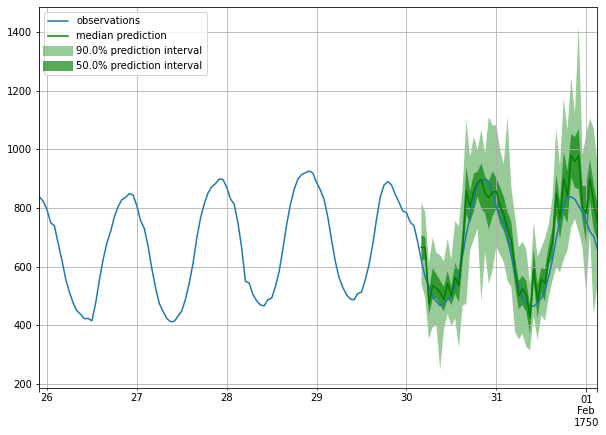

In [29]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [30]:
from gluonts.evaluation import Evaluator

In [31]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 6249.52it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [32]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 19311511.526848093,
    "abs_error": 12792952.045082092,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.797014609926564,
    "MAPE": 0.27977167807250225,
    "sMAPE": 0.1976789791534354,
    "OWA": NaN,
    "MSIS": 65.58900983542593,
    "QuantileLoss[0.1]": 5153598.086229801,
    "Coverage[0.1]": 0.12585547504025765,
    "QuantileLoss[0.5]": 12792952.08968401,
    "Coverage[0.5]": 0.5986312399355878,
    "QuantileLoss[0.9]": 8101174.432594774,
    "Coverage[0.9]": 0.8922101449275363,
    "RMSE": 4394.486491826786,
    "NRMSE": 0.599944471988968,
    "ND": 0.08788851278938141,
    "wQuantileLoss[0.1]": 0.03540559440204115,
    "wQuantileLoss[0.5]": 0.08788851309579983,
    "wQuantileLoss[0.9]": 0.05565565869543183,
    "mean_absolute_QuantileLoss": 8682574.869502863,
    "mean_wQuantileLoss": 0.059649922064424266,
    "MAE_Coverage": 0.04409219001610306
}


Individual metrics are aggregated only across time-steps.

In [33]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,5300.335938,2642.768555,31644.0,659.250000,42.371302,1.299410,0.085246,0.080512,NaN,13.448701,984.677222,0.062500,2642.768616,0.854167,1600.389874,1.000000
1,1.0,253686.125000,21640.824219,124149.0,2586.437500,165.107988,2.730640,0.180428,0.162165,NaN,15.236057,5809.663086,0.375000,21640.823486,0.958333,9709.007275,1.000000
2,2.0,29534.895833,6216.754395,65030.0,1354.791667,78.889053,1.641745,0.089502,0.093911,NaN,13.636126,3426.707947,0.000000,6216.754517,0.208333,2245.195935,0.854167
3,3.0,357859.500000,19402.527344,235783.0,4912.145833,258.982249,1.560799,0.084834,0.081621,NaN,15.707401,10760.697559,0.083333,19402.527832,0.458333,9729.374023,0.979167
4,4.0,163278.291667,14560.356445,131088.0,2731.000000,200.494083,1.512966,0.111822,0.104598,NaN,12.816461,4718.931970,0.083333,14560.356567,0.770833,8244.011865,1.000000


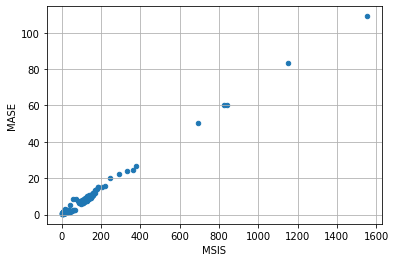

In [34]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

**Summary**: 

## 2.4 Exercise 1

Use a different model:
- Replace the `SimpleFeedForwardEstimator` with a `DeepAREstimator` 
- Configure (at least) the required hyperparameters (use the same `Trainer` as in `SimpleFeedForwardEstimator`)
- Set `solved = True` and check the result

*Solution: Appendix A.1*

`DeepAREstimator` documentation:  
https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html

In [50]:
# place your code here

In [51]:
def evaluate_solution(predictor, test_ds, plot_idx=0):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    plot_prob_forecasts(tss[plot_idx], forecasts[plot_idx])

In [52]:
solved = True

if solved:
    predictor = estimator.train(dataset.train)
    evaluate_solution(predictor, dataset.test)

AttributeError: 'NoneType' object has no attribute 'train'

## 2.5 Exercise 2

Try to underfit `DeepAREstimator`:
- Add a large `dropout_rate` 
- Decrease significantly the network size (`num_layers` and `num_cells`)
- Decrease `context_length`
- Set `solved = True` and check the result

Try to plot more time series: use the `plot_idx` argument of `evaluate_solution`

*Solution: Appendix A.2*

In [53]:
# place your code here
estimator = None

In [54]:
solved = False

if solved:
    predictor = estimator.train(dataset.train)
    evaluate_solution(predictor, dataset.test)

# 3. Custom datasets and models

## 3.1 Datasets 

In general, a dataset should satisfy some minimum format requirements to be compatible with GluonTS. In particular:
- it should be an iterable collection of data entries (dictionaries) 
- each entry corresponds to one time series
- each entry should have at least a `target` field, which contains the actual values of the time series, and a `start` field, which denotes the starting date of the time series
- there are optional fields that define possible features

Let's revisit the `m4_hourly` dataset that we have already downloaded. We can examine the first entry of the dataset and see what is the underlying structure.

In [55]:
train_entry = next(iter(dataset.train))

In [56]:
type(train_entry)

dict

In [57]:
train_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

In [58]:
# start field: starting date of the time series
train_entry['start']

Timestamp('1750-01-01 00:00:00', freq='H')

In [59]:
# target field: contains the time series values
train_entry['target'][:10]

array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370.],
      dtype=float32)

The datasets provided by GluonTS are already in the appropriate format and they can be used without any further processing steps. However, custom datasets need to be converted. Fortunately this is an easy task since the only requirements is that it is iterable and that is has a `target` and a `start` field.

For example, suppose your dataset is in the form of a `numpy.array` where the first period is given by a `pandas.Timestamp` (possibly a different value for each time series):

In [60]:
num_series = 100  
period = 24
num_steps = 10 * period  
prediction_length = 24
freq = "1H"

noise = np.random.normal(loc=1, scale=0.3, size=(num_series, num_steps))
pattern = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
target = noise + pattern
start = pd.Timestamp("01-01-2019", freq='1H')  # can be different for each time series   

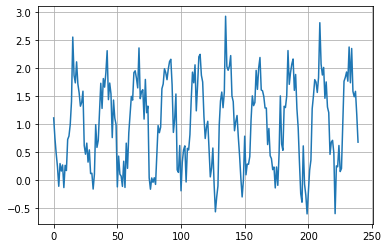

In [61]:
plt.plot(target[0])
plt.grid(which="both")
plt.show()

Now, we can split your dataset and make it available to GluonTS with just two lines of code:

In [62]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start} 
                        for x in target[:, :-prediction_length]],
                       freq=start.freq)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start} 
                       for x in target],
                      freq=start.freq)

That's it! Now we can simpy use `train_ds` and `test_ds` instead of `dataset.train` and `dataset.test`.

In the following we will use this custom dataset to train and test our models.

## 3.2 Probabilistic forecasting with a feedforward neural network 

For creating our own forecast model we need the following basic components:
- a training network
- a prediction network
- an estimator that specifies any data processing and uses the networks

### Training network

The training network can be arbitrarily complex but it should follow some basic rules:
- It should have a `hybrid_forward` method that defines what should happen when the network is called    
- Its `hybrid_forward` should return a **loss** based on the prediction and the true values. The loss for probabilistic forecasting is usually the negative log-probability of the chosen distribution

#### How can our model learn a distribution?

In order to learn a distribution we need to learn its parameters. For example, in the simple case where we assume a Gaussian distribution, we need to learn the mean and the variance that fully specify the distribution.

Each distribution that is available in GluonTS is defined by the corresponding `Distribution` class (e.g., `Gaussian`). This class defines -among others- the parameters of the distribution, its (log-)likelihood and a sampling method (given the parameters). 

However, it is not straightforward how to connect a model with such a distribution and learn its parameters. For this, each distribution comes with a `DistributionOutput` class (e.g., `GaussianOutput`) that makes this connection possible. 

The main usage of `DistributionOutput` is to take the output tensor of the model and use its last dimension as features which maps to the parameters of the distribution. For example, if the output of the network is a tensor of dimension `(a,b)`, there will be `b` features that are going to be projected and create `a` different `Distribution` objects.

#### Design choices

- Create a simple training network that defines a neural network which takes as input a window of length `context_length` and outputs the subsequent window of dimension `prediction_length`
- We need to output a `Distribution` for each time step, i.e., `prediction_length` distribution objects. Therefore the network should output `prediction_length * num_features` parameters (where `num_features` can be a hyperparameter)
- The `DistributionOutput` should take as input a tensor of shape `(prediction_length, num_features)` to create `prediction_length` distributions. Therefore, we need to reshape the network output to `(prediction_length, num_features)` 
- We can choose to fit Gaussian distributions, i.e., use the `GaussianOutput`
- The `hybrid_forward` method of the training network returns the negative log-probability as loss

Note that in all the tensors that we handle, there is an initial dimension that refers to the batch, e.g., the actual output dimension of our network will be `(batch_size, prediction_length * num_features)`. 

In [66]:
from gluonts.mx.distribution import DistributionOutput, GaussianOutput

In [67]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self, 
                 prediction_length, 
                 distr_output, 
                 num_cells, 
                 num_sample_paths=100, 
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

In [68]:
class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss

### Prediction network

The prediction network should be identical to the training network. Further, it should also comply to the following rule:
- The prediction network's `hybrid_forward` should return the predictions 

#### Design choices

- We want the prediction network to output sample paths for each time series. To achieve this we can repeat each time series as many times as the number of sample paths and do a standard forecast for each of them

In [69]:
class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length)  
        # to (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        
        # compute network output
        net_output = self.nn(repeated_past_target)

        # from (batch * num_sample_paths, prediction_length * nn_features)  
        # to (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)
       
        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()
        
        # reshape from (batch_size * num_sample_paths, prediction_length) to 
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

### Estimator

The estimator should comply with the following structure:
- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object 

A `Predictor` defines the `predictor.predict` method of a given predictor. This method takes the test dataset, it passes it through the prediction network, and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method. 

In [72]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.dataset.field_names import FieldName
from gluonts.core.component import validated
from gluonts.trainer import Trainer
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from mxnet.gluon import HybridBlock

In [73]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        distr_output: DistributionOutput,
        num_cells: int,
        num_sample_paths: int = 100,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            train_sampler=ExpectedNumInstanceSampler(num_instances=1),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [75]:
estimator = MyProbEstimator(
    prediction_length=prediction_length,
    freq=freq,
    context_length=2*prediction_length,
    distr_output=GaussianOutput(),
    num_cells=40,
    num_sample_paths=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=5, 
        learning_rate=1e-3, 
        hybridize=False, 
        num_batches_per_epoch=100,
    ),
)

The estimator can be trained using our training dataset `train_ds` just by invoking its `train` method. The training returns a predictor that can be used to predict.

In [76]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 197.77it/s, epoch=5/5, avg_epoch_loss=0.349]


In [78]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [79]:
forecast_entry = list(forecast_it)[0]
ts_entry = list(ts_it)[0]

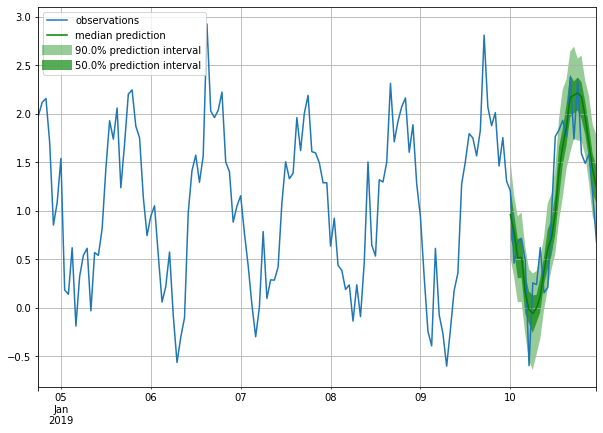

In [80]:
plot_prob_forecasts(ts_entry, forecast_entry)

## 3.4 Exercise 2  

Convert the probabilistic feedforward model to a point forecast model:
- The output of the network should be `prediction_length` parameters
- We do not need a distribution
- We need to define a loss between the predictions and the true target for the training network
- The prediction network should output directly the predictions
- Set `solved = True` and check the result

*Solution: Appendix A.3*

In [81]:
class MyPointNetwork(gluon.HybridBlock):
    pass

class MyPointTrainNetwork(MyPointNetwork):    
    pass

class MyPointPredNetwork(MyPointTrainNetwork):
    pass

class MyPointEstimator(GluonEstimator):
    pass

In [82]:
estimator = None

In [83]:
solved = False

if solved:
    predictor = estimator.train(train_ds)
    evaluate_solution(predictor, test_ds)

## <span style="color:red">WARNING:</span> YOU ARE TOO CLOSE TO THE EXERCISE SOLUTIONS

# Appendix

## A.1 Solution to Exercise 1

In [ ]:
from gluonts.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    # required
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.time_granularity,
    # optional
    context_length=100,
    num_layers=2,
    num_cells=20,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

## A.2 Solution to Exercise 2

In [ ]:
estimator = DeepAREstimator(
    # required
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.time_granularity,
    # optional
    context_length=10,
    num_layers=1,
    num_cells=5,
    dropout_rate=0.9,
    trainer=Trainer(ctx="cpu", 
                    epochs=3, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

## A.3 Solution to Exercise 3

In [ ]:
class MyPointNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

class MyPointTrainNetwork(MyPointNetwork):    
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPointPredNetwork(MyPointTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [ ]:
class MyPointEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells
            
    def create_transformation(self):
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyPointTrainNetwork:
        return MyPointTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPointPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [ ]:
estimator = MyPointEstimator(
    prediction_length=prediction_length,
    freq=freq,
    context_length=2*prediction_length,
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)